In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix,  precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input,Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, concatenate
from keras.regularizers import l1, l2, l1_l2
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.layers.experimental.preprocessing import Rescaling
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import itertools

In [2]:
# Load data
X_train_images = []
X_train_metadata = []
Y_train = []
X_test_images = []
X_test_metadata = []
Y_test = []

In [3]:
# Load training data
folderPath = os.path.join('ISIC-images-train')

df = pd.read_csv('metadata-train.csv')
df = df[df['benign_malignant'] != 'indeterminate']
df = df[df['benign_malignant'] != 'indeterminate/benign']
df = df[df['benign_malignant'] != 'indeterminate/malignant']
df['benign_malignant'] = df['benign_malignant'].replace({'benign': 0, 'malignant': 1})
df.fillna(-1)

# Process each file in the directory
for filename in os.listdir(folderPath):
    if filename.endswith(".jpg"):
        isic_id = filename[:-4]  # Remove the file extension to get ISIC ID
        if isic_id in df['isic_id'].values:
            imagePath = os.path.join(folderPath, filename)
            img = cv2.imread(imagePath)
            if img is not None:
                img = cv2.resize(img, (256, 256))
                X_train_images.append(img)
                metadata_row = df[df['isic_id'] == isic_id]
                if not metadata_row.empty:
                    row_data = metadata_row.iloc[0]
                    X_train_metadata.append(row_data.to_dict()) 
                    Y_train.append(row_data['benign_malignant'])
                else:
                    print(f"Metadata not found for {filename}")
            else:
                print(f"Failed to load image at {imagePath}")
        else:
            print(f"Image with ISIC ID {isic_id} not found in DataFrame.")
    else:
        print(f"Skipped non-image file: {filename}")

# Convert metadata list to DataFrame
X_train_metadata = pd.DataFrame(X_train_metadata)

Image with ISIC ID ISIC_0013676 not found in DataFrame.
Image with ISIC ID ISIC_0014253 not found in DataFrame.
Skipped non-image file: .DS_Store
Image with ISIC ID ISIC_0013896 not found in DataFrame.
Skipped non-image file: licenses
Skipped non-image file: attribution.txt
Image with ISIC ID ISIC_0013398 not found in DataFrame.
Image with ISIC ID ISIC_0010246 not found in DataFrame.


In [18]:
y_train

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

In [4]:
# Load testing data
folderPath = os.path.join('ISIC-images-test')

test_df = pd.read_csv('metadata-test.csv')
test_df = test_df[test_df['benign_malignant'] != 'indeterminate']
test_df = test_df[test_df['benign_malignant'] != 'indeterminate/benign']
test_df = test_df[test_df['benign_malignant'] != 'indeterminate/malignant']
test_df['benign_malignant'] = test_df['benign_malignant'].replace({'benign': 0, 'malignant': 1})
test_df.fillna(-1)

for filename in os.listdir(folderPath):
    if filename.endswith(".JPG"):  
        imagePath = os.path.join(folderPath, filename)
        img = cv2.imread(imagePath)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            metadata_row = test_df[test_df['isic_id'] == filename[:-4]]  # assuming extension is .JPG
            if not metadata_row.empty:
                X_test_images.append(img)
                X_test_metadata.append(metadata_row.iloc[0])
                Y_test.append(metadata_row['benign_malignant'].iloc[0])
            else:
                print(f"Metadata not found for {filename}")
        else:
            print(f"Failed to load image at {imagePath}")
    else:
        print(f"Skipped non-image file: {filename}")
        
X_test_metadata = pd.DataFrame(X_test_metadata)

Skipped non-image file: .DS_Store
Skipped non-image file: licenses
Skipped non-image file: attribution.txt
Metadata not found for ISIC_0013809.JPG
Metadata not found for ISIC_0015031.JPG


In [5]:
train_metadata_df = df.drop(columns = ['diagnosis', 'lesion_id', 'attribution', 'copyright_license', 'benign_malignant', 'dermoscopic_type', 'image_type', 'nevus_type', 'patient_id', 'diagnosis_confirm_type', 'concomitant_biopsy', 'personal_hx_mm', 'family_hx_mm', 'clin_size_long_diam_mm'])
test_metadata_df = test_df.drop(columns = ['diagnosis', 'lesion_id', 'attribution', 'copyright_license', 'benign_malignant', 'dermoscopic_type', 'image_type', 'nevus_type', 'patient_id', 'diagnosis_confirm_type', 'concomitant_biopsy'])

In [6]:
train_df_encoded = pd.get_dummies(train_metadata_df, columns=['anatom_site_general', 'sex', 'melanocytic'], drop_first=False)
train_df_encoded = train_df_encoded.drop(columns = ['isic_id'])
train_df_encoded.fillna(-1, inplace=True)

In [7]:
test_df_encoded = pd.get_dummies(test_metadata_df, columns=['anatom_site_general', 'sex', 'melanocytic'], drop_first=False)
test_df_encoded = test_df_encoded.drop(columns = ['isic_id'])
test_df_encoded.fillna(-1, inplace=True)

In [8]:
X_train_images = np.array(X_train_images)
X_train_metadata = train_df_encoded
X_train_metadata = np.array(X_train_metadata, dtype=np.float32)  # Ensure it's a numpy array and convert
X_test_images = np.array(X_test_images)
X_test_metadata = test_df_encoded
X_test_metadata = np.array(X_test_metadata, dtype=np.float32)  # Ensure it's a numpy array and convert
Y_train = np.array(Y_train, dtype='int32')
Y_test = np.array(Y_test, dtype='int32')
y_train = Y_train
y_test = Y_test

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image data to [0,1]
    rotation_range=40,  # Degrees range for random rotations
    width_shift_range=0.2,  # Range for horizontal shift
    height_shift_range=0.2,  # Range for vertical shift
    shear_range=0.2,  # Shearing range
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Allow horizontal flipping
    fill_mode='nearest'  # Strategy for filling newly created pixels
)
# Create a generator
train_generator = train_datagen.flow(
    X_train_images,
    Y_train,
    batch_size=64  # Adjust based on your system's capabilities
)

In [38]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(256, 256, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 64)      36928     
                                                      

In [15]:
# CNN branch for image input
image_input = Input(shape=(256, 256, 3))
x = Rescaling(1.0/255)(image_input),
x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
image_output = Dropout(0.2)(x)
cnn_branch = Model(inputs=image_input, outputs=image_output)

# Metadata branch
metadata_input = Input(shape=(12,))
y = Dense(64, activation='relu')(metadata_input)
y = Dense(32, activation='relu')(y)
metadata_output = BatchNormalization()(y)
metadata_branch = Model(inputs=metadata_input, outputs=metadata_output)

# Concatenate both branches
combined = concatenate([cnn_branch.output, metadata_branch.output])

# Add a classification head
z = Dense(128, activation='relu')(combined)
z = BatchNormalization()(z)
z = Dense(1, activation='sigmoid')(z)

# Complete model
model = Model(inputs=[cnn_branch.input, metadata_branch.input], outputs=z)

from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

callback_lr = LearningRateScheduler(scheduler)
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 256, 256, 32)         896       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 batch_normalization_5 (Bat  (None, 128, 128, 32)         128       ['max_pooling2d_3[0][0]'

In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    verbose=1,           
    restore_best_weights=True  
)

In [17]:
# Train the model
history = model.fit([X_train_images, X_train_metadata], y_train, epochs=10, batch_size=32, callbacks=[early_stopping], validation_split=0.1)

Epoch 1/10


2024-05-01 19:43:56.611740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


57/57 [==============================] - 9s 134ms/step - loss: 0.8765 - accuracy: 0.5471 - val_loss: 0.5127 - val_accuracy: 0.8000
Epoch 2/10
57/57 [==============================] - 6s 108ms/step - loss: 0.6227 - accuracy: 0.6602 - val_loss: 0.4939 - val_accuracy: 0.8050
Epoch 3/10
30/57 [==============>...............] - ETA: 2s - loss: 0.5650 - accuracy: 0.7104

KeyboardInterrupt: 

In [37]:
history = model.fit(X_train_images, y_train, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20


2024-05-01 19:38:47.590112: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


50/50 [==============================] - 8s 139ms/step - loss: 1012.9863 - accuracy: 0.5952 - val_loss: 64.2244 - val_accuracy: 0.8045
Epoch 2/20
50/50 [==============================] - 7s 131ms/step - loss: 567.6722 - accuracy: 0.6197 - val_loss: 829.3456 - val_accuracy: 0.8045
Epoch 3/20
50/50 [==============================] - 6s 125ms/step - loss: 2551.1584 - accuracy: 0.6792 - val_loss: 786.2891 - val_accuracy: 0.8045
Epoch 4/20
20/50 [===========>..................] - ETA: 3s - loss: 934.5210 - accuracy: 0.6641

KeyboardInterrupt: 

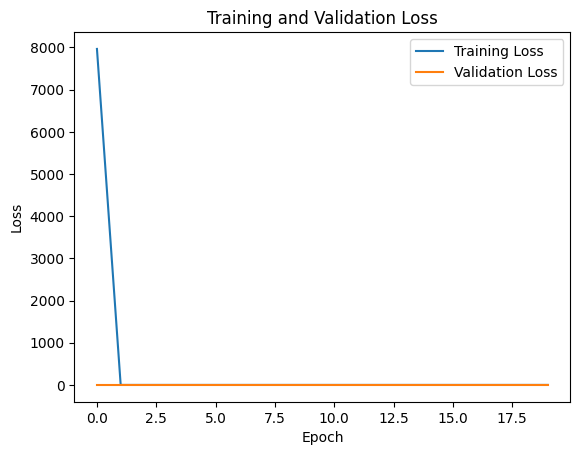

In [35]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

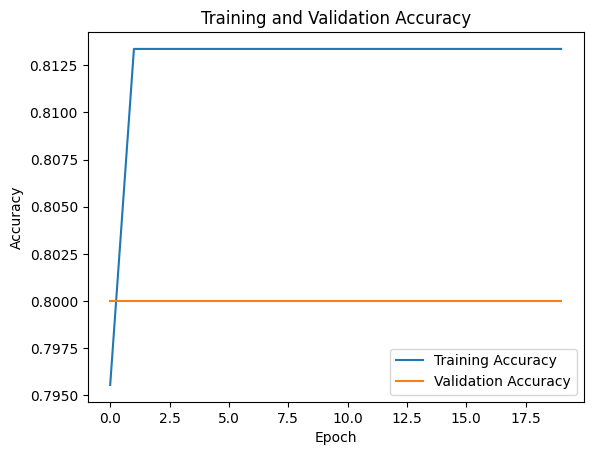

In [33]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
val_loss, val_acc = model.evaluate([X_test_images, X_test_metadata], Y_test)
print("Validation Loss:", val_loss)
print("Validation Accuracy: {:.2f}%".format(val_acc * 100))

19/19 [==============================] - 1s 37ms/step - loss: 0.5470 - accuracy: 0.7542
Validation Loss: 0.5470330119132996
Validation Accuracy: 75.42%


In [19]:
y_pred_prob = model.predict([X_test_images])

19/19 [==============================] - 0s 20ms/step


In [20]:
y_pred_prob

array([[6.03814006e-01],
       [9.43278193e-01],
       [2.63448656e-01],
       [3.42200398e-01],
       [2.01535091e-01],
       [9.97799098e-01],
       [4.11678731e-01],
       [3.33647095e-02],
       [4.65818681e-02],
       [1.46357267e-11],
       [3.08547318e-01],
       [4.94634777e-01],
       [9.99078751e-01],
       [9.83774662e-01],
       [8.53878379e-01],
       [2.02769879e-02],
       [9.69254732e-01],
       [9.45705175e-01],
       [3.84425297e-02],
       [9.87063468e-01],
       [4.04583633e-01],
       [4.95886356e-01],
       [6.70303404e-02],
       [1.00000000e+00],
       [3.33956517e-02],
       [2.93489426e-01],
       [7.11485028e-01],
       [9.99645710e-01],
       [6.13708682e-02],
       [4.43092048e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99992251e-01],
       [1.60989463e-02],
       [7.18533236e-04],
       [1.28824160e-01],
       [9.87168908e-01],
       [9.99963999e-01],
       [2.77045399e-01],
       [9.90335941e-01],


In [25]:
accuracy = np.mean(result == Y_test)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 46.13%


In [ ]:
# Confusion matrix MULTICLASS
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

In [22]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

ValueError: Found input variables with inconsistent numbers of samples: [598, 750]

In [20]:
(y_test==1).sum()

117

In [ ]:
#accuracy MULTICLASS
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage)

In [26]:
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage)

NameError: name 'y_pred' is not defined

In [ ]:
# Precision MULTICLASS
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
print("Precision:", precision)

In [ ]:
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

In [ ]:
# Recall MULTICLASS
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
print("Recall:", recall)

In [ ]:
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

In [ ]:
# F-score MULTICLASS
f_score = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
print("F-Score:", f_score)

In [ ]:
f_score = f1_score(y_test, y_pred, average='weighted')
print("F-Score:", f_score)

In [23]:
# Plot confusion matrix
labels = ['benign','malignant']
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

NameError: name 'cm' is not defined

<Figure size 800x800 with 0 Axes>

In [ ]:
# Predict input image
img = cv2.imread('../input/brain-tumor-classification-mri/Training/meningioma_tumor/m1(44).jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array = img_array.reshape(1,150,150,3)

In [ ]:
# Display input image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Input Image')
plt.show()

In [ ]:
# Predict class of input image
predicted_class = model.predict(img_array)[0]
predicted_label = labels[np.argmax(predicted_class)]
accuracy = np.max(model.predict(img_array)) * 100
print(f"The predicted class of the input image is: {predicted_label}")
print(f"The accuracy of prediction is: {accuracy:.2f}%")